# TFG Eloy Celaya - Análisis Histórico

In [1]:
#Mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import unicodedata
import json

# Importar datos y preproceso

## Valor tasado por municipio (Comunidad de Madrid)

In [3]:
#Ruta del archivo en Drive
path = "/content/drive/MyDrive/TFG/dataset_tasacion_Cmadrid.xlsx"

In [4]:
#Leer todas las hojas automáticamente
xls = pd.ExcelFile(path)

data = []
for sheet in xls.sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    df["Periodo"] = sheet
    data.append(df)

#Unir todas las hojas
df = pd.concat(data, ignore_index=True)

#Renombrar columnas
df.columns = ["Provincia", "Municipio", "Valor_Tasado", "Num_Tasaciones", "Periodo"]

#Limpiar texto y tipos
df["Municipio"] = df["Municipio"].astype(str).str.strip().str.title()
df["Valor_Tasado"] = (
    df["Valor_Tasado"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.replace("€", "", regex=False)
    .str.strip())

df["Valor_Tasado"] = pd.to_numeric(df["Valor_Tasado"], errors="coerce")

#Convertir a float el número de tasaciones
df["Num_Tasaciones"] = pd.to_numeric(df["Num_Tasaciones"], errors="coerce")

print(f"Total de registros combinados: {len(df)}")
df.head()

Total de registros combinados: 2236


,Provincia,Municipio,Valor_Tasado,Num_Tasaciones,Periodo
0,Madrid,Alcalá De Henares,2328.0,1161,T1A2005
1,Madrid,Alcobendas,3256.2,470,T1A2005
2,Madrid,Alcorcón,2645.0,652,T1A2005
3,Madrid,Aranjuez,2069.0,305,T1A2005
4,Madrid,Arganda Del Rey,2013.8,356,T1A2005


In [5]:
#Quitar columna provincia (todas son Madrid)
df_municipios = df.drop(columns=["Provincia"])

In [6]:
# Extraer año y trimestre desde el texto "T1A2024"
df_municipios["Trimestre"] = df_municipios["Periodo"].str.extract(r"T(\d)A")[0].astype(int)
df_municipios["Año"] = df_municipios["Periodo"].str.extract(r"A(\d{4})")[0].astype(int)

# Crear una columna de fecha (fin de trimestre)
mes_fin = {1: 3, 2: 6, 3: 9, 4: 12}
df_municipios["Mes"] = df_municipios["Trimestre"].map(mes_fin)
df_municipios["Fecha"] = pd.to_datetime(df_municipios["Año"].astype(str) + "-" + df_municipios["Mes"].astype(str) + "-01") + pd.offsets.MonthEnd(0)

# Ordenar por año y trimestre
df_municipios = df_municipios.sort_values(by=["Año", "Trimestre", "Municipio"]).reset_index(drop=True)

# Mostrar resultado
df_municipios.head(10)

,Municipio,Valor_Tasado,Num_Tasaciones,Periodo,Trimestre,Año,Mes,Fecha
0,Alcalá De Henares,2328.0,1161,T1A2005,1,2005,3,2005-03-31
1,Alcobendas,3256.2,470,T1A2005,1,2005,3,2005-03-31
2,Alcorcón,2645.0,652,T1A2005,1,2005,3,2005-03-31
3,Aranjuez,2069.0,305,T1A2005,1,2005,3,2005-03-31
4,Arganda Del Rey,2013.8,356,T1A2005,1,2005,3,2005-03-31
5,Boadilla Del Monte,2615.3,241,T1A2005,1,2005,3,2005-03-31
6,Collado Villalba,2406.8,402,T1A2005,1,2005,3,2005-03-31
7,Colmenar Viejo,2399.5,221,T1A2005,1,2005,3,2005-03-31
8,Coslada,2615.7,396,T1A2005,1,2005,3,2005-03-31
9,Fuenlabrada,2189.7,1106,T1A2005,1,2005,3,2005-03-31


In [7]:
df_municipios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2236 entries, 0 to 2235
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Municipio       2236 non-null   object        
 1   Valor_Tasado    2235 non-null   float64       
 2   Num_Tasaciones  2236 non-null   int64         
 3   Periodo         2236 non-null   object        
 4   Trimestre       2236 non-null   int64         
 5   Año             2236 non-null   int64         
 6   Mes             2236 non-null   int64         
 7   Fecha           2236 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 139.9+ KB


In [8]:
#Ver todos los municipios
df_municipios["Municipio"].to_list()

['Alcalá De Henares',
 'Alcobendas',
 'Alcorcón',
 'Aranjuez',
 'Arganda Del Rey',
 'Boadilla Del Monte',
 'Collado Villalba',
 'Colmenar Viejo',
 'Coslada',
 'Fuenlabrada',
 'Galapagar',
 'Getafe',
 'Leganés',
 'Madrid',
 'Majadahonda',
 'Móstoles',
 'Parla',
 'Pinto',
 'Pozuelo De Alarcón',
 'Rivas-Vaciamadrid',
 'Rozas De Madrid (Las)',
 'San Fernando De Henares',
 'San Sebastián De Los Reyes',
 'Torrejón De Ardoz',
 'Tres Cantos',
 'Valdemoro',
 'Villaviciosa De Odón',
 'Alcalá De Henares',
 'Alcobendas',
 'Alcorcón',
 'Aranjuez',
 'Arganda Del Rey',
 'Boadilla Del Monte',
 'Collado Villalba',
 'Colmenar Viejo',
 'Coslada',
 'Fuenlabrada',
 'Galapagar',
 'Getafe',
 'Leganés',
 'Madrid',
 'Majadahonda',
 'Móstoles',
 'Parla',
 'Pinto',
 'Pozuelo De Alarcón',
 'Rivas-Vaciamadrid',
 'Rozas De Madrid (Las)',
 'San Fernando De Henares',
 'San Sebastián De Los Reyes',
 'Torrejón De Ardoz',
 'Tres Cantos',
 'Valdemoro',
 'Villaviciosa De Odón',
 'Alcalá De Henares',
 'Alcobendas',
 'Alcor

In [9]:
#Corregir nombres no oficales
df_municipios["Municipio"] = df_municipios["Municipio"].replace({
    "Rozas De Madrid (Las)": "Las Rozas de Madrid"})

### Exportar csv limpio

In [ ]:
#df_municipios.to_csv("municipios.csv", index=False)
#from google.colab import files
#files.download("municipios.csv")

## Precios vivienda municipio de Madrid

In [10]:
df_distritos = pd.read_excel("/content/drive/MyDrive/TFG/Vivienda_Madrid_Distritos.xlsx")

In [11]:
df_distritos.info()
df_distritos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Distrito  153 non-null    object
 1   Barrio    153 non-null    object
 2   2007      153 non-null    object
 3   2008      153 non-null    object
 4   2009      153 non-null    object
 5   2010      153 non-null    object
 6   2011      153 non-null    object
 7   2012      153 non-null    object
 8   2013      153 non-null    object
 9   2014      153 non-null    object
 10  2015      153 non-null    object
 11  2016      153 non-null    object
 12  2017      153 non-null    object
 13  2018      153 non-null    object
 14  2019      153 non-null    object
 15  2020      153 non-null    object
 16  2021      153 non-null    object
 17  2022      153 non-null    object
 18  2023      153 non-null    object
 19  2024      153 non-null    object
dtypes: object(20)
memory usage: 24.0+ KB


,Distrito,Barrio,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Ciudad de Madrid,Ciudad de Madrid,"3.746,27","3.543,44","3.280,82","3.244,74","3.080,60","2.613,45","2.348,25","2.341,45","2.404,30","2.586,31","2.874,31","3.231,86","3.365,64","3.481,61","3.641,57","3.900,40","4.060,37","4.526,66"
1,01. Centro,01. Centro,"4.798,92","4.279,85","3.777,96","3.663,40","3.646,95","3.183,74","2.853,42","2.740,91","3.002,18","3.520,60","4.118,55","4.809,31","5.279,93","5.223,73","4.935,90","5.466,32","5.712,09","6.268,72"
2,01. Centro,011. Palacio,-,-,-,-,-,-,-,-,-,"3.268,58","4.178,57","4.255,30","5.075,34","5.034,49","4.851,23","5.410,14","5.659,44","6.399,01"
3,01. Centro,012. Embajadores,-,-,-,-,-,-,-,-,-,"3.046,56","3.538,13","4.182,95","4.481,49","4.585,04","4.300,67","4.624,29","4.825,25","5.229,59"
4,01. Centro,013. Cortes,-,-,-,-,-,-,-,-,-,"3.676,52","4.201,77","5.303,59","5.494,30","4.989,95","5.049,77","5.729,37","6.099,39","6.300,68"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,21. Barajas,211. Alameda de Osuna,-,-,-,-,-,-,-,-,-,"2.283,73","2.626,62","3.219,36","2.961,24","4.015,02","3.400,47","3.486,01","3.486,44","3.867,03"
149,21. Barajas,212. Aeropuerto,-,-,-,-,-,-,-,-,-,"0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00","0,00"
150,21. Barajas,213. Casco Histórico de Barajas,-,-,-,-,-,-,-,-,-,"1.987,78","2.269,95","2.795,69","2.978,60","2.697,80","3.077,10","3.202,44","3.285,62","3.560,60"
151,21. Barajas,214. Timón,-,-,-,-,-,-,-,-,-,"2.410,28","2.775,45","3.594,92","3.106,26","2.639,48","3.267,12","3.505,72","3.745,13","4.094,58"


In [12]:
#Reemplazar guiones por NaN
df_distritos = df_distritos.replace("-", np.nan)

#Convertir columnas de años a numérico
year_cols = [col for col in df_distritos.columns if col.isdigit()]

for col in year_cols:
    df_distritos[col] = (
        df_distritos[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .str.replace(",", ".", regex=False)
        .astype(float))

In [13]:
df_distritos.head()

,Distrito,Barrio,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Ciudad de Madrid,Ciudad de Madrid,3746.27,3543.44,3280.82,3244.74,3080.60,2613.45,2348.25,2341.45,2404.30,2586.31,2874.31,3231.86,3365.64,3481.61,3641.57,3900.40,4060.37,4526.66
1,01. Centro,01. Centro,4798.92,4279.85,3777.96,3663.40,3646.95,3183.74,2853.42,2740.91,3002.18,3520.60,4118.55,4809.31,5279.93,5223.73,4935.90,5466.32,5712.09,6268.72
2,01. Centro,011. Palacio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3268.58,4178.57,4255.30,5075.34,5034.49,4851.23,5410.14,5659.44,6399.01
3,01. Centro,012. Embajadores,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3046.56,3538.13,4182.95,4481.49,4585.04,4300.67,4624.29,4825.25,5229.59
4,01. Centro,013. Cortes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3676.52,4201.77,5303.59,5494.30,4989.95,5049.77,5729.37,6099.39,6300.68


In [14]:
#Nos quedamos solo con filas donde Distrito == Barrio (nivel distrito) + Ciudad de Madrid
df_distritos = df_distritos[df_distritos["Distrito"] == df_distritos["Barrio"]].copy()

df_distritos.head()

,Distrito,Barrio,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Ciudad de Madrid,Ciudad de Madrid,3746.27,3543.44,3280.82,3244.74,3080.60,2613.45,2348.25,2341.45,2404.30,2586.31,2874.31,3231.86,3365.64,3481.61,3641.57,3900.40,4060.37,4526.66
1,01. Centro,01. Centro,4798.92,4279.85,3777.96,3663.40,3646.95,3183.74,2853.42,2740.91,3002.18,3520.60,4118.55,4809.31,5279.93,5223.73,4935.90,5466.32,5712.09,6268.72
8,02. Arganzuela,02. Arganzuela,3770.95,4214.07,3918.01,3508.03,3313.51,2886.48,2344.66,2306.09,2239.40,2692.43,3060.83,3693.97,3927.78,4214.21,4210.73,4489.71,4556.68,5406.62
16,03. Retiro,03. Retiro,4371.00,4231.51,3908.82,3929.06,3662.02,3296.95,3000.11,2928.80,3151.86,3254.71,3784.14,4444.42,4864.84,4759.56,4818.16,5284.27,5501.02,6278.37
23,04. Salamanca,04. Salamanca,5229.72,4961.80,4602.84,4602.69,4513.73,3857.07,3633.39,3564.52,3734.45,4169.05,4816.71,5400.24,5857.87,5511.90,5737.17,6496.29,7332.40,7749.88


In [15]:
df_distritos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 0 to 147
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Distrito  22 non-null     object 
 1   Barrio    22 non-null     object 
 2   2007      22 non-null     float64
 3   2008      22 non-null     float64
 4   2009      22 non-null     float64
 5   2010      22 non-null     float64
 6   2011      22 non-null     float64
 7   2012      22 non-null     float64
 8   2013      22 non-null     float64
 9   2014      22 non-null     float64
 10  2015      22 non-null     float64
 11  2016      22 non-null     float64
 12  2017      22 non-null     float64
 13  2018      22 non-null     float64
 14  2019      22 non-null     float64
 15  2020      22 non-null     float64
 16  2021      22 non-null     float64
 17  2022      22 non-null     float64
 18  2023      22 non-null     float64
 19  2024      22 non-null     float64
dtypes: float64(18), object(2)
memory usage

In [16]:
df_long = df_distritos.melt(
    id_vars="Distrito",
    value_vars=year_cols,
    var_name="Año",
    value_name="€/m²")

df_long["Año"] = df_long["Año"].astype(int)

df_long["Distrito"] = (
    df_long["Distrito"]
    .str.replace(r"^\d+\.\s*", "", regex=True))

df_long.info()
df_long.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Distrito  396 non-null    object 
 1   Año       396 non-null    int64  
 2   €/m²      396 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.4+ KB


,Distrito,Año,€/m²
0,Ciudad de Madrid,2007,3746.27
1,Centro,2007,4798.92
2,Arganzuela,2007,3770.95
3,Retiro,2007,4371.00
4,Salamanca,2007,5229.72


Exportar como csv para la app

In [ ]:
#df_long.to_csv("distritos.csv", index=False)
#from google.colab import files
#files.download("distritos.csv")

## Media valor tasado España y Madrid

In [17]:
df = pd.read_csv("/content/drive/MyDrive/TFG/Media España vs Madird.csv", sep=";")

In [18]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Region        244 non-null    object 
 1   Año           244 non-null    float64
 2   Trimestre     244 non-null    float64
 3   Valor Tasado  244 non-null    object 
dtypes: float64(2), object(2)
memory usage: 8.1+ KB


In [19]:
df = df.dropna(subset=["Region", "Año", "Trimestre", "Valor Tasado"]).copy()

# Limpiar texto y convertir correctamente los tipos
df["Region"] = df["Region"].astype(str).str.strip()
df["Año"] = df["Año"].astype(int)
df["Trimestre"] = df["Trimestre"].astype(int)

df["Valor Tasado"] = (
    df["Valor Tasado"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.replace("€", "", regex=False)
    .str.strip())

# Convertir a número decimal (manteniendo el punto como separador)
df["Valor Tasado"] = pd.to_numeric(df["Valor Tasado"], errors="coerce")

# Crear columna Fecha (último mes del trimestre)
mes_fin = {1: 3, 2: 6, 3: 9, 4: 12}
df["Fecha"] = pd.to_datetime(
    df["Año"].astype(str) + "-" + df["Trimestre"].map(mes_fin).astype(str) + "-01") + pd.offsets.MonthEnd(0)

df_medias = df

In [20]:
df_medias.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 0 to 243
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Region        244 non-null    object        
 1   Año           244 non-null    int64         
 2   Trimestre     244 non-null    int64         
 3   Valor Tasado  244 non-null    float64       
 4   Fecha         244 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 11.4+ KB


In [21]:
df_medias.head()

,Region,Año,Trimestre,Valor Tasado,Fecha
0,España,1995,1,670.8,1995-03-31
1,España,1995,2,686.0,1995-06-30
2,España,1995,3,682.6,1995-09-30
3,España,1995,4,692.7,1995-12-31
4,Madrid,1995,1,1078.4,1995-03-31


### Exportar como csv para la web

In [ ]:
#df_medias.to_csv("medias.csv", index=False)
#from google.colab import files
#files.download("medias.csv")

# Merge de ambas

In [22]:
# Renombrar Columnas
df_medias = df_medias.rename(columns={"Valor Tasado": "Valor_Tasado"})

# Añadir medias Madrid
df_merge = df_municipios.merge(
    df_medias[df_medias["Region"] == "Madrid"][["Año", "Trimestre", "Valor_Tasado"]],
    on=["Año", "Trimestre"],
    how="left",
    suffixes=("", "_Madrid"))

# Añadir medias España
df_merge = df_merge.merge(
    df_medias[df_medias["Region"] == "España"][["Año", "Trimestre", "Valor_Tasado"]],
    on=["Año", "Trimestre"],
    how="left",
    suffixes=("", "_España"))

# Diferencias absolutas y porcentuales
df_merge["Dif_Madrid"] = df_merge["Valor_Tasado"] - df_merge["Valor_Tasado_Madrid"]
df_merge["Dif_España"] = df_merge["Valor_Tasado"] - df_merge["Valor_Tasado_España"]

df_merge["Pct_Madrid"] = (df_merge["Valor_Tasado"] / df_merge["Valor_Tasado_Madrid"] - 1) * 100
df_merge["Pct_España"] = (df_merge["Valor_Tasado"] / df_merge["Valor_Tasado_España"] - 1) * 100

df_merge.head(10)

,Municipio,Valor_Tasado,Num_Tasaciones,Periodo,Trimestre,Año,Mes,Fecha,Valor_Tasado_Madrid,Valor_Tasado_España,Dif_Madrid,Dif_España,Pct_Madrid,Pct_España
0,Alcalá De Henares,2328.0,1161,T1A2005,1,2005,3,2005-03-31,2617.4,1685.4,-289.4,642.6,-11.056774,38.127447
1,Alcobendas,3256.2,470,T1A2005,1,2005,3,2005-03-31,2617.4,1685.4,638.8,1570.8,24.405899,93.200427
2,Alcorcón,2645.0,652,T1A2005,1,2005,3,2005-03-31,2617.4,1685.4,27.6,959.6,1.054482,56.936039
3,Aranjuez,2069.0,305,T1A2005,1,2005,3,2005-03-31,2617.4,1685.4,-548.4,383.6,-20.952090,22.760176
4,Arganda Del Rey,2013.8,356,T1A2005,1,2005,3,2005-03-31,2617.4,1685.4,-603.6,328.4,-23.061053,19.484989
5,Boadilla Del Monte,2615.3,241,T1A2005,1,2005,3,2005-03-31,2617.4,1685.4,-2.1,929.9,-0.080232,55.173846
6,Collado Villalba,2406.8,402,T1A2005,1,2005,3,2005-03-31,2617.4,1685.4,-210.6,721.4,-8.046153,42.802895
7,Colmenar Viejo,2399.5,221,T1A2005,1,2005,3,2005-03-31,2617.4,1685.4,-217.9,714.1,-8.325055,42.369764
8,Coslada,2615.7,396,T1A2005,1,2005,3,2005-03-31,2617.4,1685.4,-1.7,930.3,-0.064950,55.197579
9,Fuenlabrada,2189.7,1106,T1A2005,1,2005,3,2005-03-31,2617.4,1685.4,-427.7,504.3,-16.340643,29.921680


## Exportar datos finales como csv para la app

In [ ]:
#df_merge.to_csv("precios_municipios.csv", index=False)

In [ ]:
#from google.colab import files
#files.download("precios_municipios.csv")


## Variación anual Comunidad de Madrid

In [23]:
df_madrid_qoq = (
    df_medias[df_medias["Region"] == "Madrid"]
    .sort_values("Fecha")
    .copy())

df_madrid_qoq["QoQ_growth_%"] = (
    df_madrid_qoq["Valor_Tasado"]
    .pct_change() * 100)

df_madrid_qoq.head()


,Region,Año,Trimestre,Valor_Tasado,Fecha,QoQ_growth_%
4,Madrid,1995,1,1078.4,1995-03-31,NaN
5,Madrid,1995,2,1078.4,1995-06-30,0.000000
6,Madrid,1995,3,1086.2,1995-09-30,0.723294
7,Madrid,1995,4,1115.0,1995-12-31,2.651445
12,Madrid,1996,1,1104.5,1996-03-31,-0.941704


# Análisis Histórico

Incrementos trimestrales Comunidad de Madrid

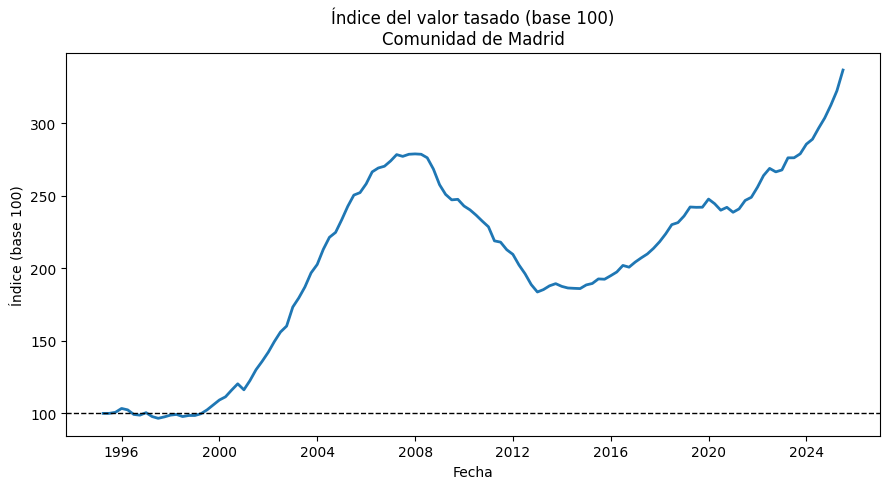

In [24]:
df_index = df_madrid_qoq.copy()
base_value = df_index.iloc[0]["Valor_Tasado"]
df_index["Index"] = 100 * df_index["Valor_Tasado"] / base_value

plt.figure(figsize=(9, 5))
plt.plot(df_index["Fecha"], df_index["Index"], linewidth=2)
plt.axhline(100, color="black", linestyle="--", linewidth=1)
plt.title("Índice del valor tasado (base 100)\nComunidad de Madrid")
plt.xlabel("Fecha")
plt.ylabel("Índice (base 100)")
plt.tight_layout()
plt.show()

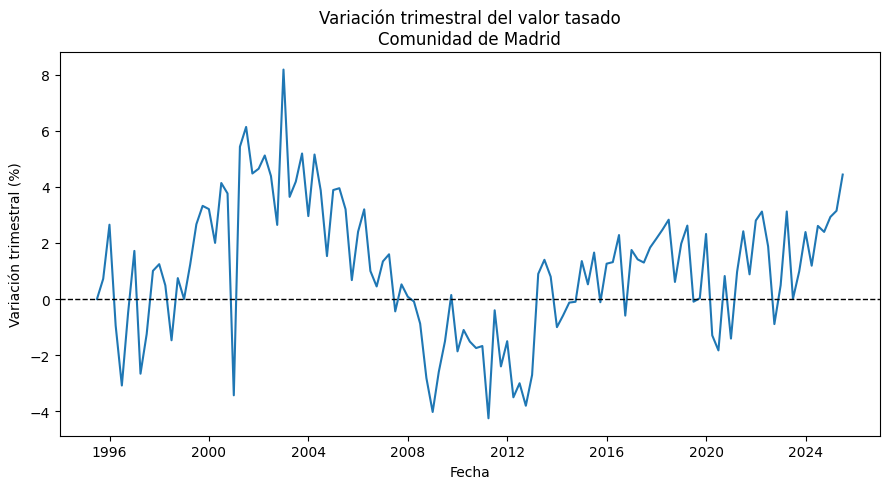

In [25]:
plt.figure(figsize=(9, 5))
plt.plot(df_madrid_qoq["Fecha"], df_madrid_qoq["QoQ_growth_%"])
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Variación trimestral del valor tasado\nComunidad de Madrid")
plt.xlabel("Fecha")
plt.ylabel("Variación trimestral (%)")
plt.tight_layout()
plt.show()

### Evolución de precios

Medias España y Madrid

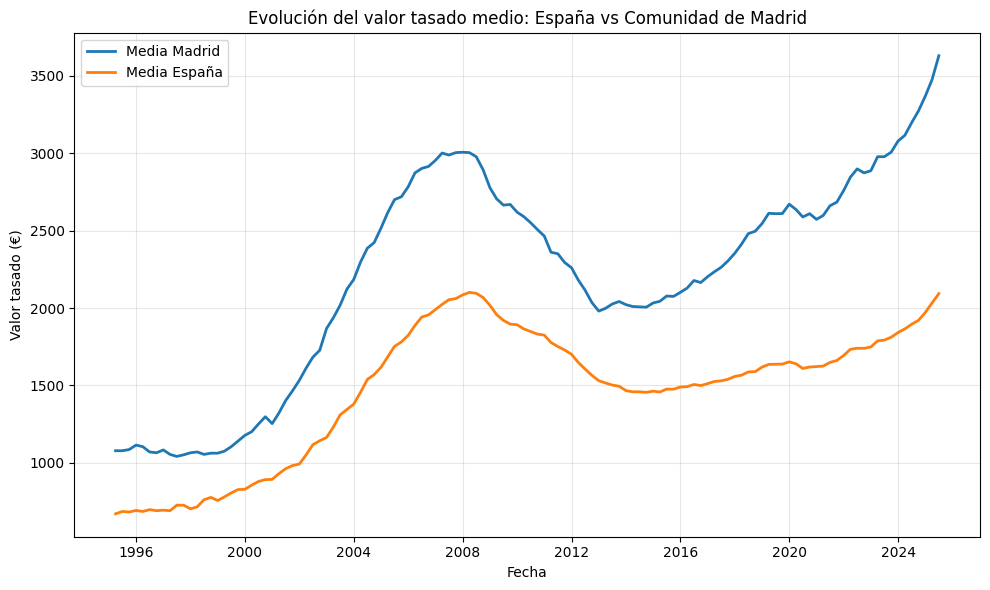

In [26]:
# Medias Madrid

plt.figure(figsize=(10,6))
mad = df_medias[df_medias["Region"] == "Madrid"].sort_values("Fecha")
plt.plot(mad["Fecha"], mad["Valor_Tasado"], label="Media Madrid", linewidth=2)

# Medias España
esp = df_medias[df_medias["Region"] == "España"].sort_values("Fecha")
plt.plot(esp["Fecha"], esp["Valor_Tasado"], label="Media España", linewidth=2)

plt.title("Evolución del valor tasado medio: España vs Comunidad de Madrid")
plt.xlabel("Fecha")
plt.ylabel("Valor tasado (€)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Municipios premium

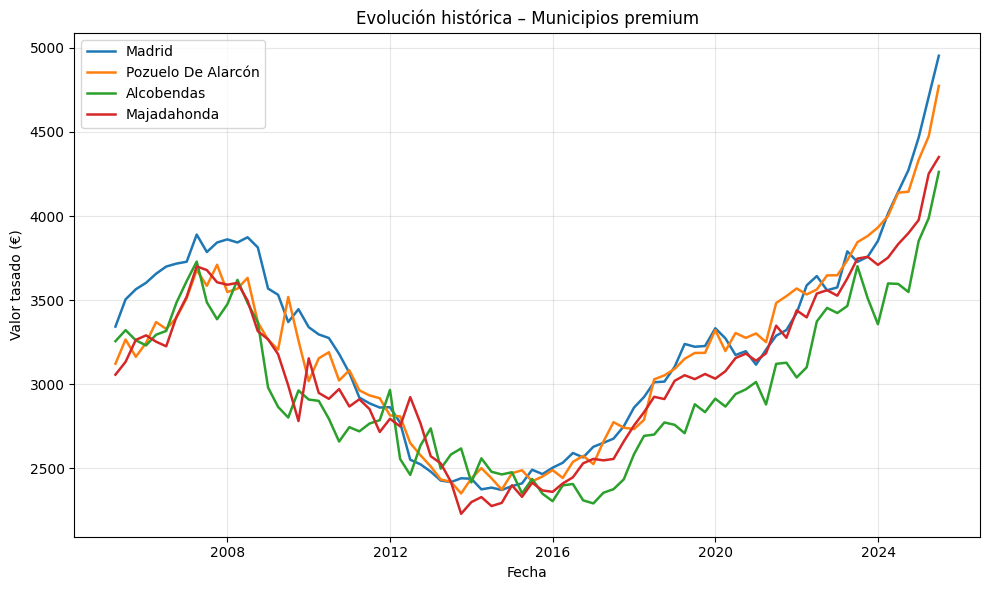

In [27]:
premium = ["Madrid", "Pozuelo De Alarcón", "Alcobendas",
          "Majadahonda"]

plt.figure(figsize=(10,6))
for m in premium:
    data = df_merge[df_merge["Municipio"] == m].sort_values("Fecha")
    plt.plot(data["Fecha"], data["Valor_Tasado"], label=m, linewidth=1.8)

plt.title("Evolución histórica – Municipios premium")
plt.xlabel("Fecha")
plt.ylabel("Valor tasado (€)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Municipios Intermedios

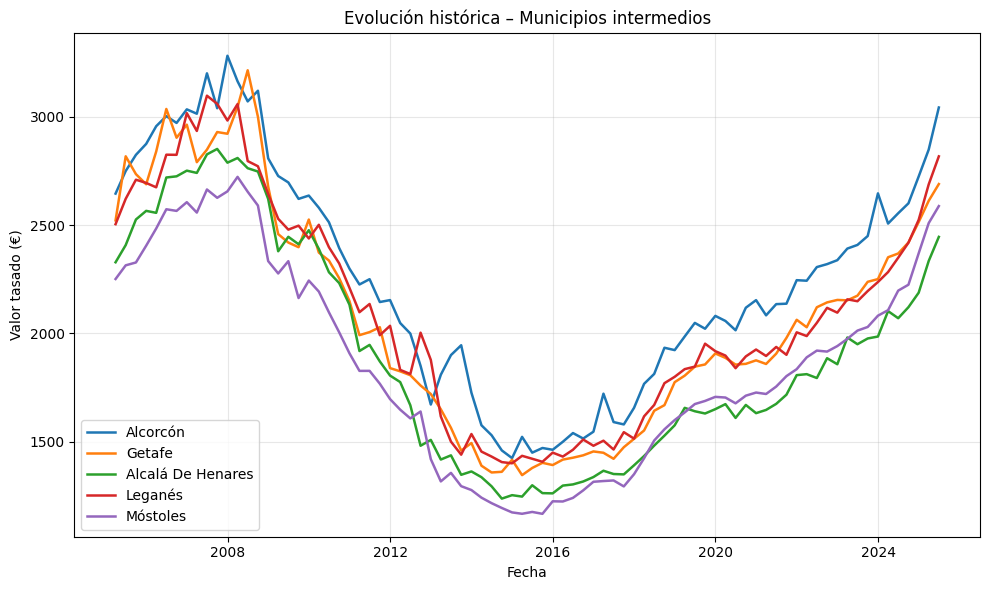

In [28]:
intermedios = ["Alcorcón", "Getafe", "Alcalá De Henares", "Leganés", "Móstoles"]

plt.figure(figsize=(10,6))
for m in intermedios:
    data = df_merge[df_merge["Municipio"] == m].sort_values("Fecha")
    plt.plot(data["Fecha"], data["Valor_Tasado"], label=m, linewidth=1.8)

plt.title("Evolución histórica – Municipios intermedios")
plt.xlabel("Fecha")
plt.ylabel("Valor tasado (€)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Municipios económicos

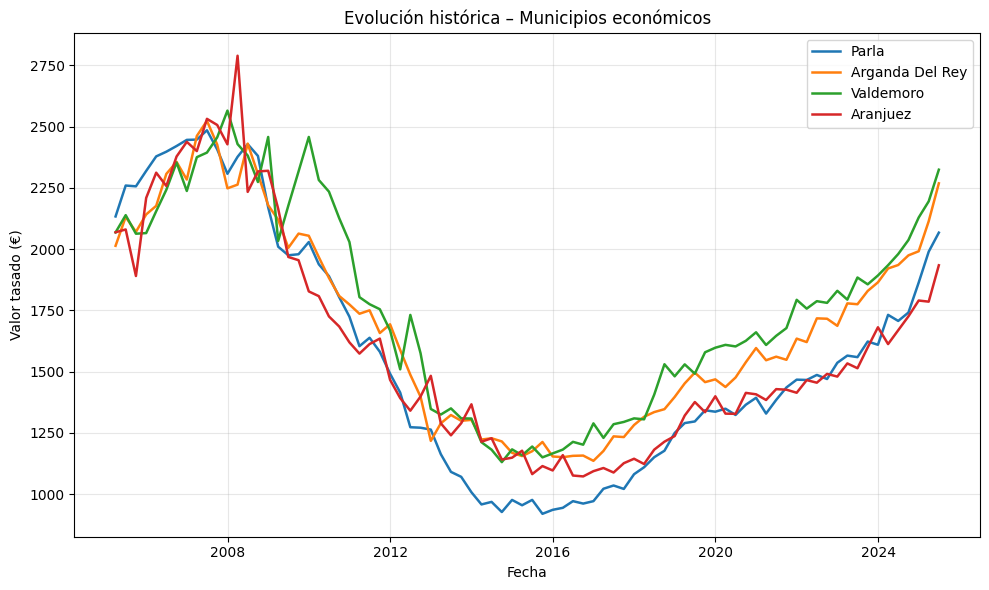

In [29]:
economicos = ["Parla", "Arganda Del Rey", "Valdemoro", "Aranjuez"]

plt.figure(figsize=(10,6))
for m in economicos:
    data = df_merge[df_merge["Municipio"] == m].sort_values("Fecha")
    plt.plot(data["Fecha"], data["Valor_Tasado"], label=m, linewidth=1.8)

plt.title("Evolución histórica – Municipios económicos")
plt.xlabel("Fecha")
plt.ylabel("Valor tasado (€)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Municipio más caro vs más barato

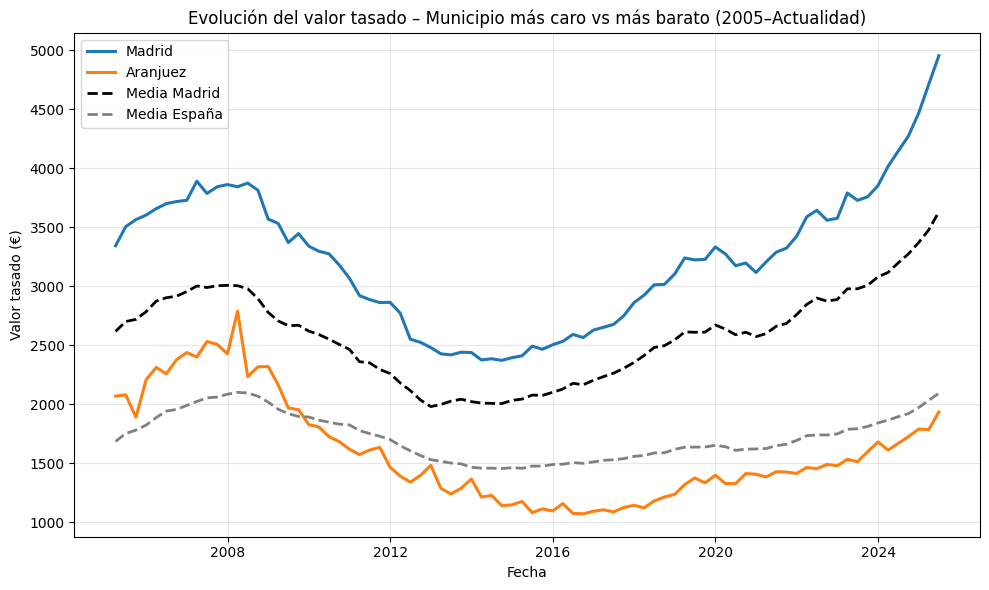

In [30]:
top = "Madrid"
bottom = "Aranjuez"

df_plot = df_merge[df_merge["Fecha"] >= "2005-01-01"]

top_data = df_plot[df_plot["Municipio"] == top].sort_values("Fecha")
bottom_data = df_plot[df_plot["Municipio"] == bottom].sort_values("Fecha")

mad = df_medias[(df_medias["Region"] == "Madrid") &
                (df_medias["Fecha"] >= "2005-01-01")].sort_values("Fecha")

esp = df_medias[(df_medias["Region"] == "España") &
                (df_medias["Fecha"] >= "2005-01-01")].sort_values("Fecha")

plt.figure(figsize=(10,6))

plt.plot(top_data["Fecha"], top_data["Valor_Tasado"],
         label=top, linewidth=2.2)

plt.plot(bottom_data["Fecha"], bottom_data["Valor_Tasado"],
         label=bottom, linewidth=2.2)

plt.plot(mad["Fecha"], mad["Valor_Tasado"],
         label="Media Madrid", linestyle="--", color="black", linewidth=2)

plt.plot(esp["Fecha"], esp["Valor_Tasado"],
         label="Media España", linestyle="--", color="gray", linewidth=2)

plt.title("Evolución del valor tasado – Municipio más caro vs más barato (2005–Actualidad)")
plt.xlabel("Fecha")
plt.ylabel("Valor tasado (€)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Mapa interactivo por años

### Crear archivo GeoJSON

In [31]:
#Importar de drive y visualizar muestra
gdf = gpd.read_file("/content/drive/MyDrive/TFG/recintos_municipales_inspire_peninbal_etrs89.shp")
gdf.head()

,INSPIREID,COUNTRY,NATLEV,NATLEVNAME,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry
0,ES.IGN.BDDAE.34040707901,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34040707901,Ariany,ES5,ES53,ES532,"POLYGON ((3.0842 39.6567, 3.0882 39.65763, 3.0..."
1,ES.IGN.BDDAE.34040707902,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34040707902,Es Migjorn Gran,ES5,ES53,ES533,"MULTIPOLYGON (((4.02986 39.91556, 4.02984 39.9..."
2,ES.IGN.BDDAE.34164848057,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34164848057,Lekeitio,ES2,ES21,ES213,"MULTIPOLYGON (((-2.51336 43.37696, -2.51328 43..."
3,ES.IGN.BDDAE.34164848058,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34164848058,Mallabia,ES2,ES21,ES213,"POLYGON ((-2.57799 43.21733, -2.57798 43.21733..."
4,ES.IGN.BDDAE.34164848059,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34164848059,Mañaria,ES2,ES21,ES213,"POLYGON ((-2.69325 43.1482, -2.69323 43.14821,..."


In [32]:
#Columnas del archivo
gdf.columns

Index(['INSPIREID', 'COUNTRY', 'NATLEV', 'NATLEVNAME', 'NATCODE', 'NAMEUNIT',
       'CODNUT1', 'CODNUT2', 'CODNUT3', 'geometry'],
      dtype='object')

In [33]:
#Preproceso

#Filtrar solo Madrid
gdf_mad = gdf[gdf["CODNUT3"] == "ES300"].copy()
len(gdf_mad)

# Función para normalizar nombres (sin tildes, en minúsculas)
def norm(s):
    if pd.isna(s):
        return ""
    s = str(s)
    s = unicodedata.normalize("NFKD", s)
    s = "".join(c for c in s if not unicodedata.combining(c))
    return s.lower().strip()

#Simplificar mapeo para minimizar recursos
gdf_mad["geometry"] = gdf_mad["geometry"].simplify(0.002, preserve_topology=True)

# Clave normalizada del shapefile
gdf_mad["muni_key"] = gdf_mad["NAMEUNIT"].apply(norm)

# Preparar dataset de municipios
df = df_municipios.copy()
df["muni_key"] = df["Municipio"].apply(norm)

#Dejar solo una entrada por año para aumentar velocidad de carga
df_municipios_año = (
    df.groupby(["muni_key", "Año"], as_index=False)
      .agg({"Valor_Tasado": "mean"}))

# Fusionar todos los periodos con todos los municipios de Madrid
gdf_all = gdf_mad.merge(df_municipios_año, on="muni_key", how="inner").copy()

# Resetear índice y crear ID único para plotly
gdf_all = gdf_all.reset_index(drop=True)
gdf_all["id"] = gdf_all.index.astype(str)

# Asegurar que no haya timestamps (plotly falla)
if "Fecha" in gdf_all.columns:
    gdf_all["Fecha"] = gdf_all["Fecha"].astype(str)

In [34]:
geojson = json.loads(gdf_all.to_json())

In [ ]:
# Exportar GeoJSON
#gdf_all.to_file(
#    "/content/municipios_madrid.geojson",
#    driver="GeoJSON")
#from google.colab import files
#files.download("/content/municipios_madrid.geojson")

Mapa valor tasado anual

In [ ]:
import plotly.express as px

fig = px.choropleth_mapbox(
    gdf_all,
    geojson=geojson,
    locations="id",
    featureidkey="properties.id",
    color="Valor_Tasado",
    animation_frame="Año",
    mapbox_style="carto-positron",
    zoom=8.5,
    height=700,
    center={"lat": 40.3468, "lon": -3.7038},
    opacity=0.7,
    color_continuous_scale="YlOrRd",
    labels={"Valor_Tasado": "€/m²", "NAMEUNIT" : "Municipio"},
    hover_name="NAMEUNIT",
    hover_data={"NAMEUNIT": False, "Valor_Tasado": True, "id": False})

fig.update_layout(
    title="Valor tasado por municipio – Comunidad de Madrid (2005-2025)",
    margin=dict(r=0, l=0, t=40, b=0))


fig.show()

Mapa incremento anual

In [ ]:
#Asegurar orden temporal correcto
gdf_all = gdf_all.sort_values(["NAMEUNIT", "Año"])

#Incremento anual porcentual
gdf_all["Incremento_%"] = (
    gdf_all
    .groupby("NAMEUNIT")["Valor_Tasado"]
    .pct_change() * 100)

In [ ]:
fig = px.choropleth_mapbox(
    gdf_all,
    geojson=geojson,
    locations="id",
    featureidkey="properties.id",
    color="Incremento_%",
    animation_frame="Año",
    mapbox_style="carto-positron",
    zoom=8.5,
    height=700,
    center={"lat": 40.3468, "lon": -3.7038},
    opacity=0.7,
    color_continuous_scale="RdYlGn",
    range_color=(-20, 15),
    labels={
        "Incremento_%": "Incremento anual (%)",
        "Municipio": "Municipio",
        "Valor_Tasado": "€/m²"},
    hover_name="NAMEUNIT",
    hover_data={
        "NAMEUNIT": False,
        "Incremento_%": ":.2f",
        "Valor_Tasado": ":.0f",
        "id": False})

fig.update_layout(
    title="Incremento anual del valor tasado por municipio – Comunidad de Madrid (2005–2025)",
    margin=dict(r=0, l=0, t=40, b=0))

fig.show()

# Precio de la vivienda en el Municipio de Madrid

Todos los distritos vs Ciudad de Madrid

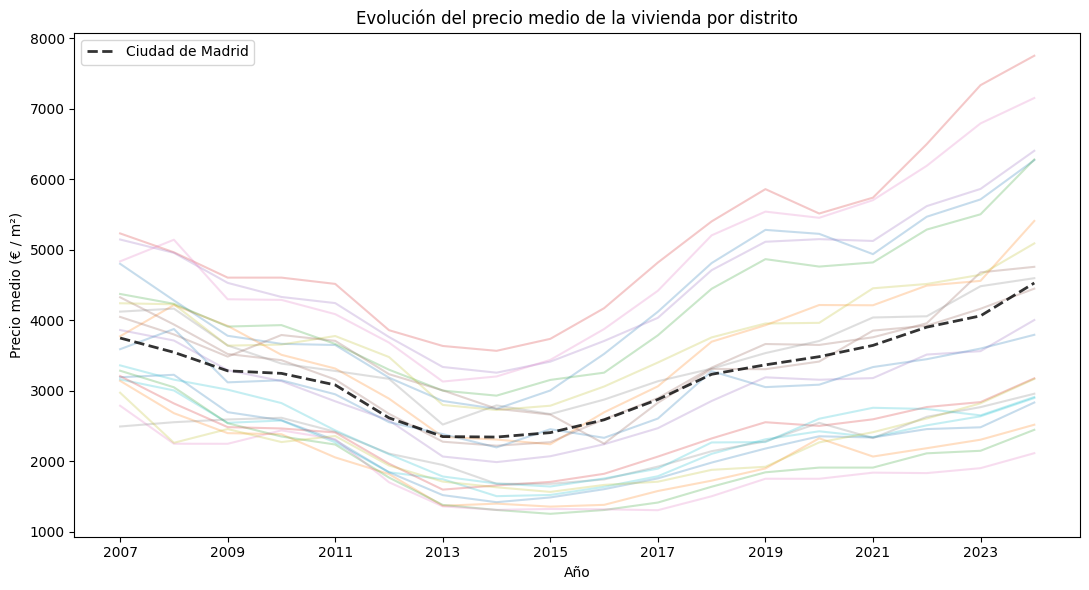

In [35]:
plt.figure(figsize=(11, 6))

# Distritos
for distrito in df_long["Distrito"].unique():
    if distrito != "Ciudad de Madrid":
        subset = df_long[df_long["Distrito"] == distrito]
        plt.plot(
            subset["Año"],
            subset["€/m²"],
            alpha=0.25)

# Ciudad de Madrid como referencia
city = df_long[df_long["Distrito"] == "Ciudad de Madrid"]
plt.plot(
    city["Año"],
    city["€/m²"],
    color="black",
    linewidth=2,
    linestyle="--",
    alpha=0.8,
    label="Ciudad de Madrid")

plt.title("Evolución del precio medio de la vivienda por distrito")
plt.xlabel("Año")
plt.ylabel("Precio medio (€ / m²)")

plt.xticks(
    ticks=range(df_long["Año"].min(), df_long["Año"].max() + 1, 2))

plt.legend()
plt.tight_layout()
plt.show()

Top 5 distritos VS Ciudad de Madrid

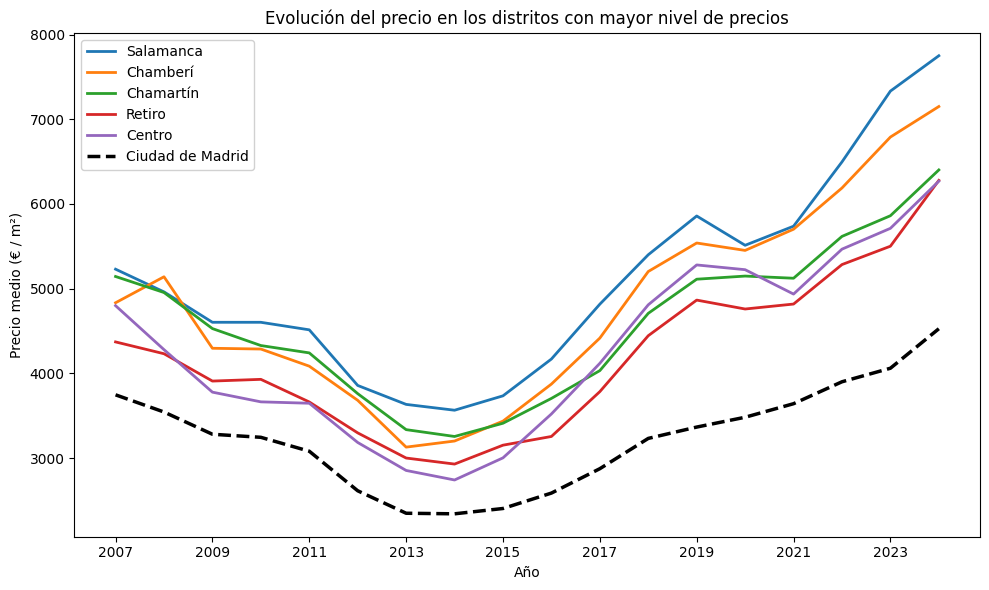

In [36]:
top_districts = (
    df_long[df_long["Año"] == 2024]
    .sort_values("€/m²", ascending=False)
    .head(5)["Distrito"]
    .tolist())

plt.figure(figsize=(10, 6))

for distrito in top_districts:
    subset = df_long[df_long["Distrito"] == distrito]
    plt.plot(
        subset["Año"],
        subset["€/m²"],
        linewidth=2,
        label=distrito)

city = df_long[df_long["Distrito"] == "Ciudad de Madrid"]
plt.plot(
    city["Año"],
    city["€/m²"],
    color="black",
    linestyle="--",
    linewidth=2.5,
    label="Ciudad de Madrid")

plt.title("Evolución del precio en los distritos con mayor nivel de precios")
plt.xlabel("Año")
plt.ylabel("Precio medio (€ / m²)")

# Eje X sin decimales
plt.xticks(
    ticks=range(df_long["Año"].min(), df_long["Año"].max() + 1, 2))

# Leyenda dentro del gráfico (zona limpia)
plt.legend(
    loc="upper left",
    frameon=True,
    framealpha=0.9)

plt.tight_layout()
plt.show()

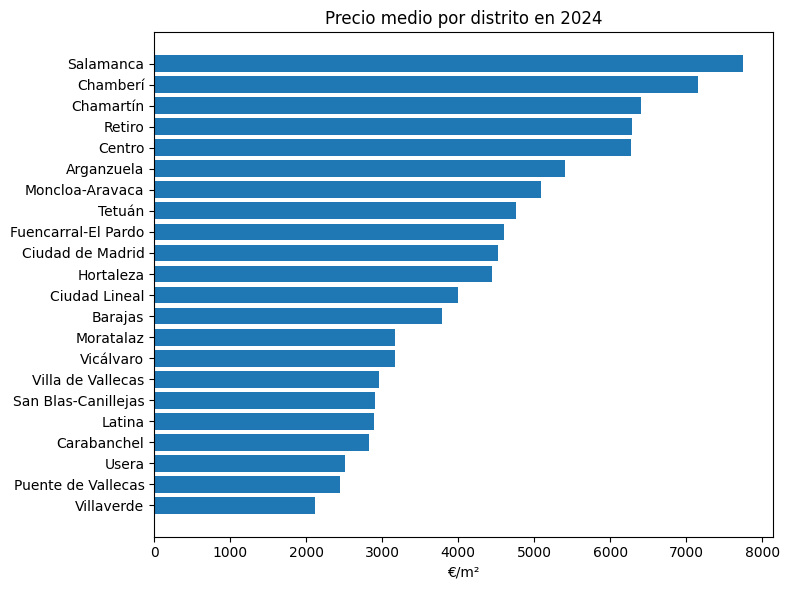

In [37]:
df_2024 = df_long[df_long["Año"] == 2024] \
    .sort_values("€/m²", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(df_2024["Distrito"], df_2024["€/m²"])
plt.gca().invert_yaxis()
plt.title("Precio medio por distrito en 2024")
plt.xlabel("€/m²")
plt.tight_layout()
plt.show()

Crecimiento del precio por distrito desde 2015

In [38]:
# Filtrar años inicial y final
df_2015 = df_long[df_long["Año"] == 2015][["Distrito", "€/m²"]]
df_2024 = df_long[df_long["Año"] == 2024][["Distrito", "€/m²"]]

# Renombrar columnas
df_2015 = df_2015.rename(columns={"€/m²": "price_2015"})
df_2024 = df_2024.rename(columns={"€/m²": "price_2024"})

# Merge por distrito
df_growth = df_2015.merge(df_2024, on="Distrito", how="inner")

# Calcular crecimiento porcentual
df_growth["Growth_%"] = (
    (df_growth["price_2024"] / df_growth["price_2015"] - 1) * 100)

# Ordenar de mayor a menor crecimiento
df_growth = df_growth.sort_values("Growth_%", ascending=False)

df_growth = df_growth.set_index("Distrito")

df_growth.head()

,price_2015,price_2024,Growth_%
Distrito,,,
Arganzuela,2239.40,5406.62,141.431633
Tetuán,2269.07,4755.80,109.592476
Centro,3002.18,6268.72,108.805601
Chamberí,3435.82,7150.33,108.111310
Salamanca,3734.45,7749.88,107.524000


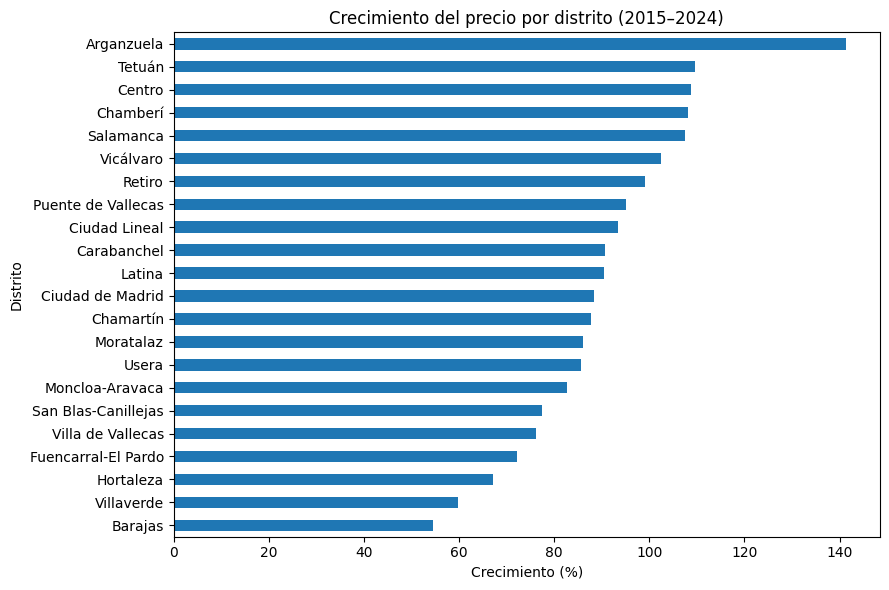

In [39]:
plt.figure(figsize=(9, 6))

df_growth["Growth_%"].plot(kind="barh")

plt.gca().invert_yaxis()  # mayor crecimiento arriba
plt.title("Crecimiento del precio por distrito (2015–2024)")
plt.xlabel("Crecimiento (%)")
plt.ylabel("Distrito")

plt.tight_layout()
plt.show()


# Análisis actual

## Comunidad de Madrid

## Crear df

In [40]:
# Último año y trimestre disponibles
ultimo_año = df_municipios["Año"].max()
ultimo_trim = (
    df_municipios[df_municipios["Año"] == ultimo_año]["Trimestre"].max())

ultimo_año, ultimo_trim

(2025, 2)

In [41]:
df_actual_municipios = (
    df_municipios[
        (df_municipios["Año"] == ultimo_año) &
        (df_municipios["Trimestre"] == ultimo_trim)
    ][["Municipio", "Valor_Tasado"]]
    .rename(columns={"Valor_Tasado": "precio_actual"}))

df_actual_municipios.head()

,Municipio,precio_actual
2208,Alcalá De Henares,2445.2
2209,Alcobendas,4262.1
2210,Alcorcón,3042.4
2211,Aranjuez,1934.3
2212,Arganda Del Rey,2268.8


Mapa actual por municipio

In [42]:
# Preparar claves
gdf_map_actual = gdf_mad.copy()

gdf_map_actual = gdf_map_actual.merge(
    df_actual_municipios.assign(
        muni_key=df_actual_municipios["Municipio"].apply(norm)),
    left_on="muni_key",
    right_on="muni_key",
    how="left")

gdf_map_actual.head()

,INSPIREID,COUNTRY,NATLEV,NATLEVNAME,NATCODE,NAMEUNIT,CODNUT1,CODNUT2,CODNUT3,geometry,muni_key,Municipio,precio_actual
0,ES.IGN.BDDAE.34132828049,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34132828049,Coslada,ES3,ES30,ES300,"POLYGON ((-3.53119 40.42008, -3.53023 40.41471...",coslada,Coslada,2831.0
1,ES.IGN.BDDAE.34132828050,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34132828050,Cubas de la Sagra,ES3,ES30,ES300,"POLYGON ((-3.87632 40.19122, -3.86908 40.20108...",cubas de la sagra,NaN,NaN
2,ES.IGN.BDDAE.34132828051,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34132828051,Chapinería,ES3,ES30,ES300,"POLYGON ((-4.23555 40.39329, -4.21725 40.4039,...",chapineria,NaN,NaN
3,ES.IGN.BDDAE.34132828052,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34132828052,Chinchón,ES3,ES30,ES300,"POLYGON ((-3.58093 40.09899, -3.57567 40.1133,...",chinchon,NaN,NaN
4,ES.IGN.BDDAE.34132828053,ES,https://inspire.ec.europa.eu/codelist/Administ...,Municipio,34132828053,Daganzo de Arriba,ES3,ES30,ES300,"POLYGON ((-3.48319 40.55549, -3.47406 40.57152...",daganzo de arriba,NaN,NaN


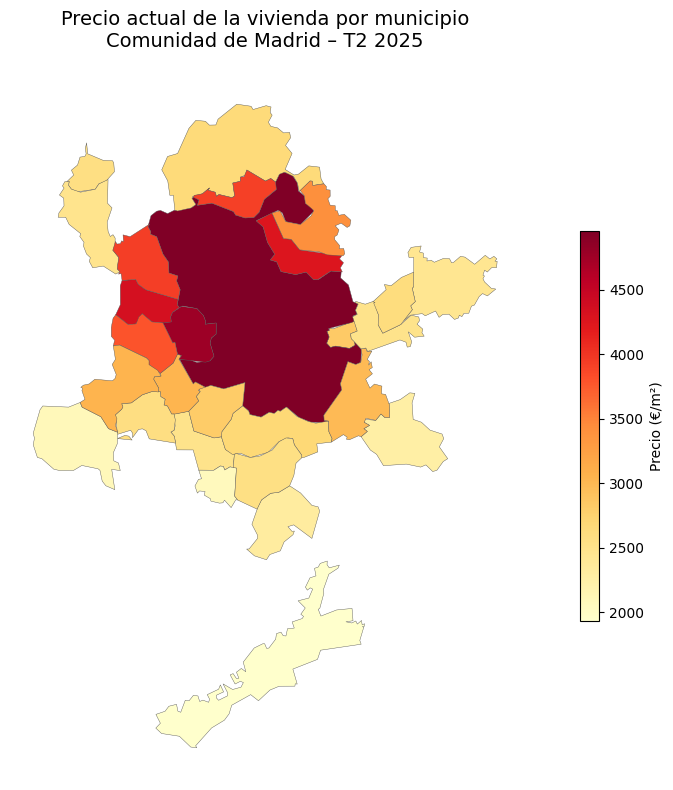

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(30, 8))

gdf_map_actual.plot(
    column="precio_actual",
    cmap="YlOrRd",
    linewidth=0.3,
    edgecolor="#555555",
    legend=True,
    ax=ax,
    legend_kwds={
        "label": "Precio (€/m²)",
        "shrink": 0.55,
        "pad": 0.02,
        "format": "%.0f"})

ax.set_title(
    f"Precio actual de la vivienda por municipio\n"
    f"Comunidad de Madrid – T{ultimo_trim} {ultimo_año}",
    fontsize=14,
    pad=18)

ax.axis("off")

plt.tight_layout()
plt.show()


##Dist precios actuales

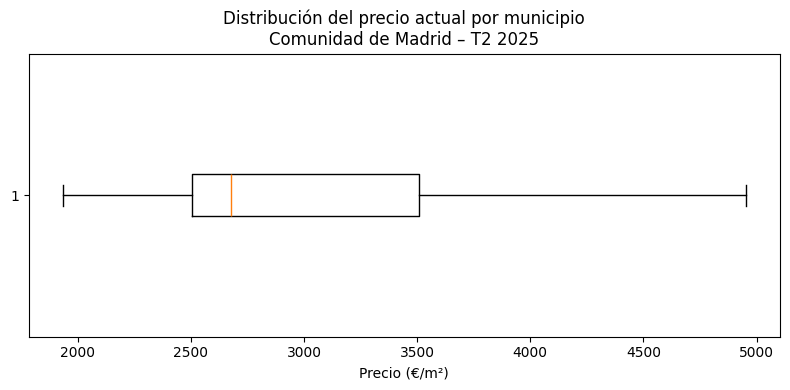

In [44]:
plt.figure(figsize=(8, 4))

plt.boxplot(
    df_actual_municipios["precio_actual"],
    vert=False)

plt.xlabel("Precio (€/m²)")
plt.title(
    f"Distribución del precio actual por municipio\n"
    f"Comunidad de Madrid – T{ultimo_trim} {ultimo_año}")

plt.tight_layout()
plt.show()

## Ranking municipal

In [45]:
df_rank_mun = df_actual_municipios.sort_values(
    "precio_actual", ascending=False)

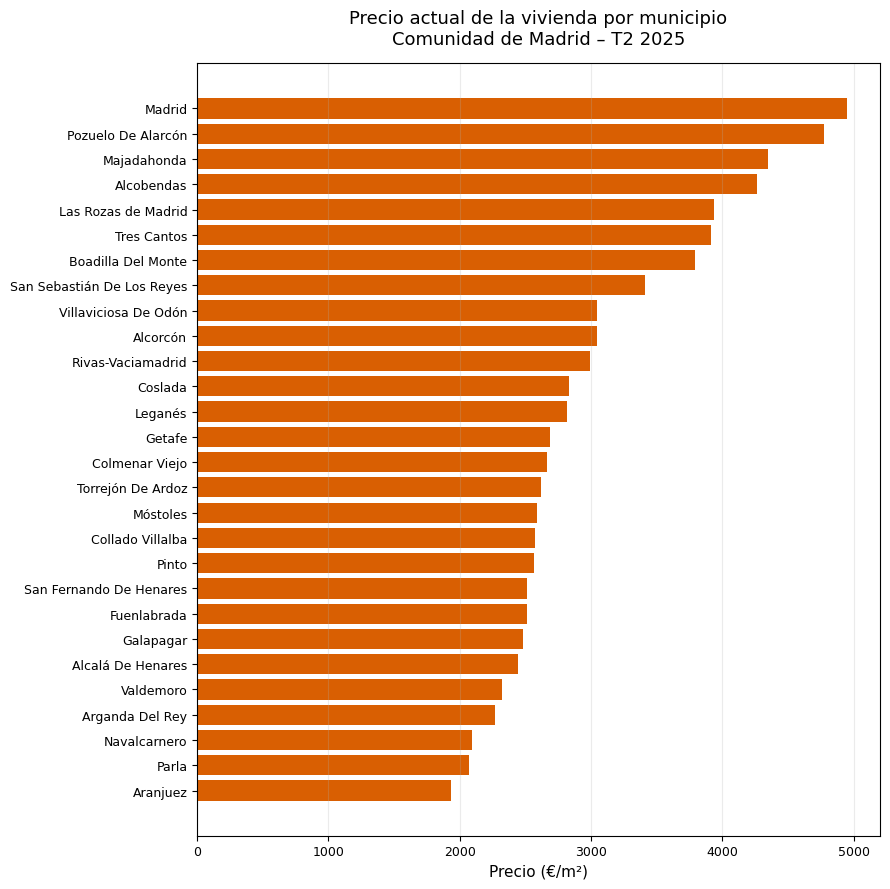

In [46]:
plt.figure(figsize=(9, 9))  # más alto

plt.barh(
    df_rank_mun["Municipio"],
    df_rank_mun["precio_actual"],
    height=0.8,              # barras más gruesas
    color="#d95f02")

plt.gca().invert_yaxis()

plt.xlabel("Precio (€/m²)", fontsize=11)
plt.ylabel("")

plt.title(
    f"Precio actual de la vivienda por municipio\n"
    f"Comunidad de Madrid – T{ultimo_trim} {ultimo_año}",
    fontsize=13,
    pad=14)

plt.yticks(fontsize=9)
plt.xticks(fontsize=9)

plt.grid(axis="x", alpha=0.25)

plt.tight_layout()
plt.show()

solo top y bottom

In [47]:
df_plot = pd.concat([
    df_rank_mun.head(10),
    df_rank_mun.tail(10)])

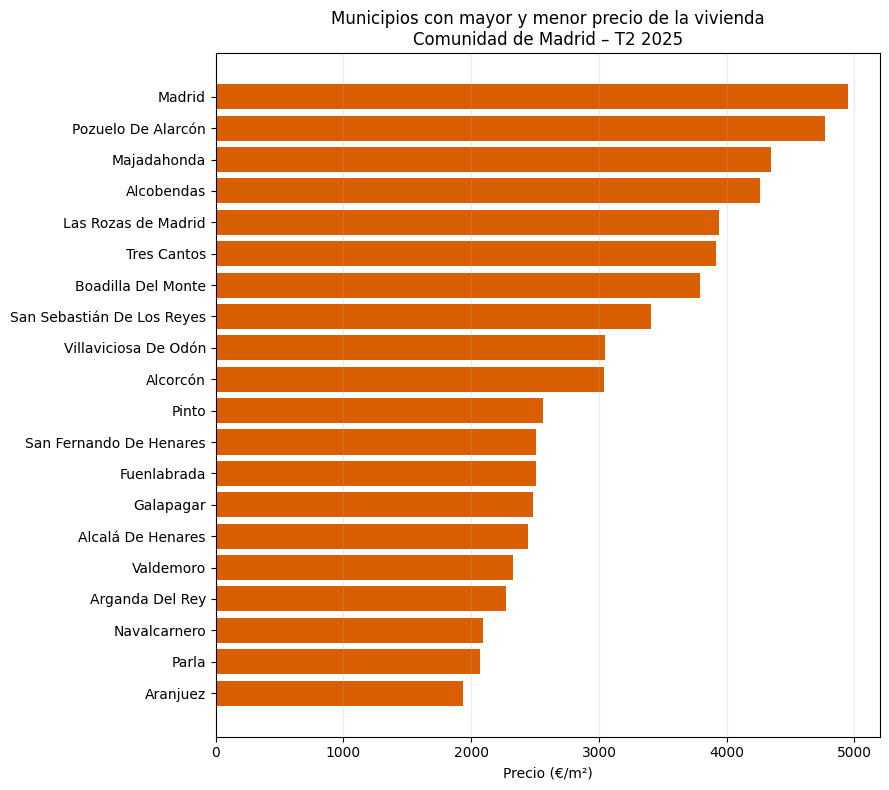

In [48]:
plt.figure(figsize=(9, 8))

plt.barh(
    df_plot["Municipio"],
    df_plot["precio_actual"],
    height=0.8,
    color="#d95f02")

plt.gca().invert_yaxis()

plt.xlabel("Precio (€/m²)")
plt.title(
    f"Municipios con mayor y menor precio de la vivienda\n"
    f"Comunidad de Madrid – T{ultimo_trim} {ultimo_año}")

plt.grid(axis="x", alpha=0.25)
plt.tight_layout()
plt.show()

## Madrid vs resto

In [49]:
precio_madrid = df_actual_municipios.loc[
    df_actual_municipios["Municipio"] == "Madrid",
    "precio_actual"
].values[0]

precio_resto = df_actual_municipios.loc[
    df_actual_municipios["Municipio"] != "Madrid",
    "precio_actual"]

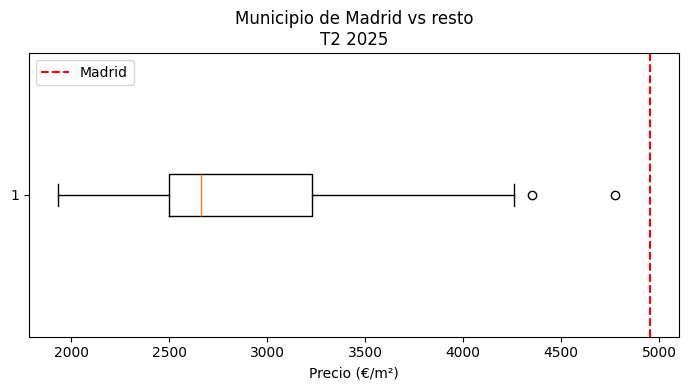

In [50]:
plt.figure(figsize=(7, 4))

plt.boxplot(precio_resto, vert=False)
plt.axvline(
    precio_madrid,
    color="red",
    linestyle="--",
    label="Madrid")

plt.xlabel("Precio (€/m²)")
plt.title(
    f"Municipio de Madrid vs resto\n"
    f"T{ultimo_trim} {ultimo_año}")
plt.legend()

plt.tight_layout()
plt.show()

# Distritos de Madrid

In [51]:
df_actual_distritos = (
    df_long[df_long["Año"] == df_long["Año"].max()]
    .sort_values("€/m²", ascending=False))

df_actual_distritos.head()

,Distrito,Año,€/m²
378,Salamanca,2024,7749.88
381,Chamberí,2024,7150.33
379,Chamartín,2024,6401.56
377,Retiro,2024,6278.37
375,Centro,2024,6268.72


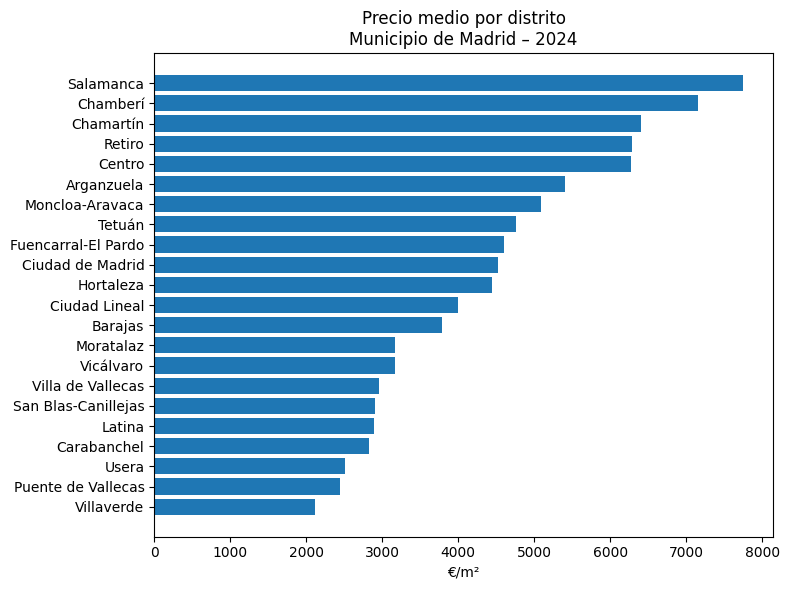

In [52]:
plt.figure(figsize=(8, 6))

plt.barh(
    df_actual_distritos["Distrito"],
    df_actual_distritos["€/m²"])

plt.gca().invert_yaxis()
plt.xlabel("€/m²")
plt.title(
    f"Precio medio por distrito\n"
    f"Municipio de Madrid – {df_long['Año'].max()}")

plt.tight_layout()
plt.show()